# Gamma Fingerprint

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct  3 22:53:01 2023

@author: hkpen
"""
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import hdbscan
from sklearn import manifold

D={}
mat_id_list= []
sg_number_list=[]
formulae_list=[]
band_gap_list=[]
nelements_list=[]
elements_list=[]
discovery_route_list=[]
formula_anonymous_list=[]
exfoliation_energy_list=[]
decomposition_energy_list=[]
crystal_list=[]
point_group_list=[]

open and read db file

In [10]:
with open('db.json') as f:
    for jsonobj in f:
        strDict=json.loads(jsonobj)
        mat_id_list.append(strDict['material_id'])
        sg_number_list.append(strDict['sg_number'])
        formulae_list.append(strDict['formula_pretty'])
        band_gap_list.append(strDict['bandgap'])
        nelements_list.append(strDict['nelements'])
        elements_list.append(strDict['elements'])
        discovery_route_list.append(strDict['discovery_process'])
        formula_anonymous_list.append(strDict['formula_anonymous'])
        if 'exfoliation_energy_per_atom' in strDict:
            exfoliation_energy_list.append(strDict['exfoliation_energy_per_atom'])
        else:
            exfoliation_energy_list.append(float("nan"))
        if 'decomposition_energy' in strDict:
            decomposition_energy_list.append(strDict['decomposition_energy'])
        else:
            decomposition_energy_list.append(float("nan"))
        crystal_list.append(strDict['spacegroup']['crystal_system'])
        point_group_list.append(strDict['spacegroup']['point_group'])

## Create the Fingerprints - Put the Band Energies between (4,-4)eV at k=(0,0) in 32 Bins

In [11]:
def calc_gamma_fingerprint(bands_dict, n_bins=32, e_range=[-4, 4]):
    band_energies = np.array(bands_dict["bands"]["1"]) - bands_dict["efermi"]
    band_energies_gamma = band_energies[:, 0]
    counts, edges = np.histogram(band_energies_gamma, bins=n_bins, range=e_range)
    density = counts / len(band_energies_gamma)
    return density

In [12]:
fingerprint_length = 32
fingerprints = []
indices = []

print(len(mat_id_list))

for i, name in enumerate(mat_id_list):
    
    BS_dir= '/media/tw/HDD/Misc/mphys/bands/'
    filename_bands=BS_dir+name+'.json'
    if not os.path.isfile(filename_bands):
        print("No such file %s" % filename_bands)
        continue
    bands_dict=json.load(open(filename_bands))
    
    fingerprints.append(calc_gamma_fingerprint(bands_dict, n_bins=fingerprint_length))
    indices.append(name)

loaded_fingerprints.shape

6351
No such file /media/tw/HDD/Misc/mphys/bands/2dm-9.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-35.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-69.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-77.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-106.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-113.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-116.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-151.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-168.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-212.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-246.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-291.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-302.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-414.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-446.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-452.json
No such file /media/tw/HDD/Misc/mphys/bands/2dm-472.json
No such file /media/tw/HDD/Misc

(5279, 32)

In [20]:
np.savetxt("gamma_fingerprints.csv", fingerprints, delimiter=",")
np.savetxt("gamma_indices.csv", indices, delimiter=",", fmt="%s")

In [2]:
loaded_fingerprints = np.genfromtxt("flat_mat_DOS_fingerprints.csv", delimiter=",")
loaded_indices = np.genfromtxt("flat_mat_DOS_indices.csv", delimiter=",")
loaded_fingerprints
np.isnan(loaded_fingerprints).sum()

0

## Clustering with Hdbscan

In [11]:
clusterer = hdbscan.HDBSCAN()

In [12]:
clusterer.fit(loaded_fingerprints)

HDBSCAN()

In [13]:
clusterer.labels_, np.unique(clusterer.labels_, return_counts=True)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 (array([-1,  0,  1], dtype=int64), array([ 404, 1534,   14], dtype=int64)))

### Trying a number of metrics

In [14]:
hdbscan.dist_metrics.METRIC_MAPPING

{'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'rogerst

In [18]:
awkward_metrics_and_duplicates = ["minkowski", # require extra args
                                  "seuclidean",
                                  "mahalanobis",
                                  "wminkowski", 
                                  "kulsinski", 
                                  "haversine", 
                                  "cosine", "arccos", 
                                  "pyfunc",
                                  "l2", "p", # same as euclidean
                                  "cityblock", "l1", #same as manhattan
                                  "infinity", # same as chebychev
                                  "dice", "sokalsneath", # same as jaccard
                                  "sokalmichener" # same as rogerstanimoto
                                 ]

metric_label_dict = {}
for metric in hdbscan.dist_metrics.METRIC_MAPPING:
    if metric in awkward_metrics_and_duplicates:
        continue

    print(metric)
    clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric=metric, cluster_selection_method='leaf', min_cluster_size=5, min_samples=5, p=0.2)
    clusterer.fit(loaded_fingerprints)
    print(np.unique(clusterer.labels_, return_counts=True))
    print(" ")

    metric_label_dict[metric] = clusterer.labels_

euclidean
(array([-1,  0,  1,  2], dtype=int64), array([1907,   14,   24,    7], dtype=int64))
 
manhattan
(array([-1,  0,  1,  2,  3], dtype=int64), array([1886,    6,   14,   39,    7], dtype=int64))
 
chebyshev
(array([-1,  0,  1], dtype=int64), array([1906,   40,    6], dtype=int64))
 
hamming
(array([-1], dtype=int64), array([1952], dtype=int64))
 
canberra
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64), array([1840,    5,    5,    5,    5,   18,    8,   16,   27,    5,   18],
      dtype=int64))
 
braycurtis
(array([-1,  0,  1,  2,  3,  4,  5], dtype=int64), array([1888,   12,    5,    8,   17,   14,    8], dtype=int64))
 
matching
(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,

## Displaying the Clusters with T-SNE

### Fit T-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1952 samples in 0.003s...
[t-SNE] Computed neighbors for 1952 samples in 12.044s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1952
[t-SNE] Computed conditional probabilities for sample 1952 / 1952
[t-SNE] Mean sigma: 22.164295
[t-SNE] Computed conditional probabilities in 0.283s
[t-SNE] Iteration 50: error = 74.6915588, gradient norm = 0.0438184 (50 iterations in 2.519s)
[t-SNE] Iteration 100: error = 74.5636292, gradient norm = 0.0527891 (50 iterations in 2.065s)
[t-SNE] Iteration 150: error = 74.3369751, gradient norm = 0.0310687 (50 iterations in 1.383s)
[t-SNE] Iteration 200: error = 74.3933868, gradient norm = 0.0412019 (50 iterations in 1.277s)
[t-SNE] Iteration 250: error = 74.1491928, gradient norm = 0.0789706 (50 iterations in 1.109s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.149193
[t-SNE] Iteration 300: error = 1.9947940, gradient norm = 0.0095858 (50 iterations in 1.088

[t-SNE] Iteration 4150: error = 1.7151678, gradient norm = 0.0001357 (50 iterations in 0.336s)
[t-SNE] Iteration 4200: error = 1.7151767, gradient norm = 0.0000909 (50 iterations in 0.368s)
[t-SNE] Iteration 4250: error = 1.7151542, gradient norm = 0.0000909 (50 iterations in 0.354s)
[t-SNE] Iteration 4300: error = 1.7151327, gradient norm = 0.0000969 (50 iterations in 0.367s)
[t-SNE] Iteration 4350: error = 1.7151190, gradient norm = 0.0000801 (50 iterations in 0.354s)
[t-SNE] Iteration 4400: error = 1.7151099, gradient norm = 0.0001164 (50 iterations in 0.430s)
[t-SNE] Iteration 4450: error = 1.7150681, gradient norm = 0.0000745 (50 iterations in 0.439s)
[t-SNE] Iteration 4500: error = 1.7150592, gradient norm = 0.0001446 (50 iterations in 0.450s)
[t-SNE] Iteration 4550: error = 1.7150478, gradient norm = 0.0001032 (50 iterations in 0.394s)
[t-SNE] Iteration 4600: error = 1.7150457, gradient norm = 0.0001031 (50 iterations in 0.448s)
[t-SNE] Iteration 4650: error = 1.7150085, gradien

[t-SNE] Iteration 8500: error = 1.7141665, gradient norm = 0.0000640 (50 iterations in 0.573s)
[t-SNE] Iteration 8550: error = 1.7141389, gradient norm = 0.0001045 (50 iterations in 0.533s)
[t-SNE] Iteration 8600: error = 1.7141285, gradient norm = 0.0000998 (50 iterations in 0.506s)
[t-SNE] Iteration 8650: error = 1.7141069, gradient norm = 0.0000663 (50 iterations in 0.535s)
[t-SNE] Iteration 8700: error = 1.7141422, gradient norm = 0.0000555 (50 iterations in 0.593s)
[t-SNE] Iteration 8750: error = 1.7141020, gradient norm = 0.0001901 (50 iterations in 0.619s)
[t-SNE] Iteration 8800: error = 1.7140683, gradient norm = 0.0000668 (50 iterations in 0.638s)
[t-SNE] Iteration 8850: error = 1.7140517, gradient norm = 0.0000902 (50 iterations in 0.535s)
[t-SNE] Iteration 8900: error = 1.7140698, gradient norm = 0.0000559 (50 iterations in 0.503s)
[t-SNE] Iteration 8950: error = 1.7140796, gradient norm = 0.0000826 (50 iterations in 0.581s)
[t-SNE] Iteration 9000: error = 1.7140484, gradien

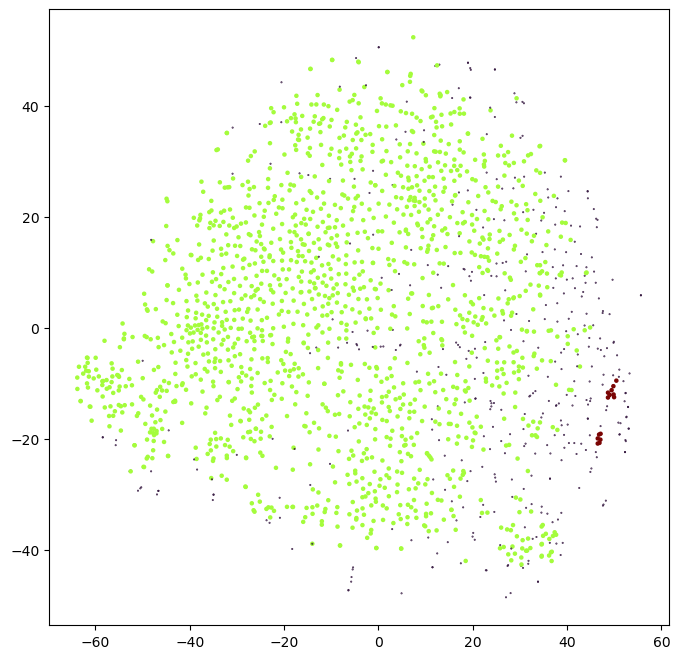

In [7]:
n_components=2
labels = clusterer.labels_
tsne = manifold.TSNE(n_components=n_components, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
fingerprints_2d = tsne.fit_transform(loaded_fingerprints)
fig = plt.figure(figsize=(8,8))
s=np.ones((len(labels),1))*5
s[labels==-1]=0.2
c=labels
#c[labels==-1]=-5
plt.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=s, c=c*5, cmap="turbo")

### Plot Clustering with Different Metrics

In [19]:
def get_indices_by_label(cluster_labels):
    unique_labels = np.unique(cluster_labels)  # Get unique cluster labels
    
    label_indices = {}
    for label in unique_labels:
        indices = np.where(cluster_labels == label)[0]  # Find indices for the current label
        label_indices[label] = indices.tolist()  # Convert indices to a list
    
    return label_indices

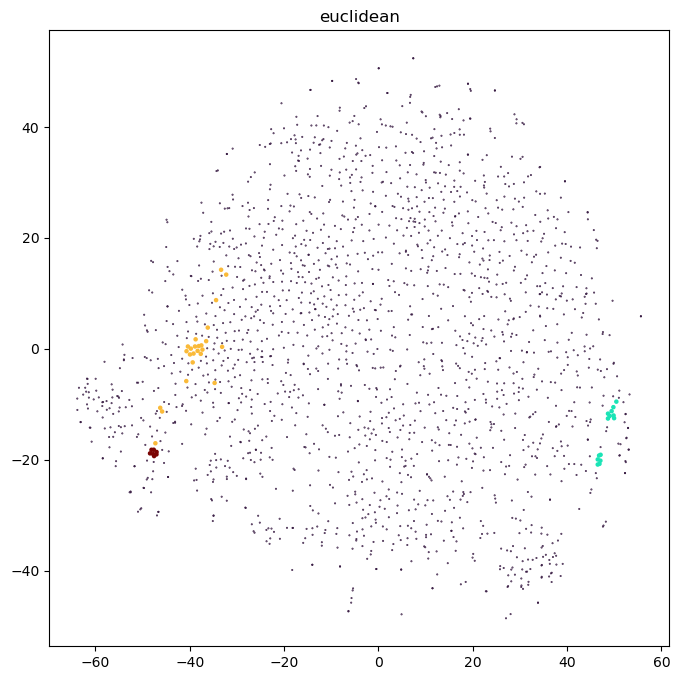

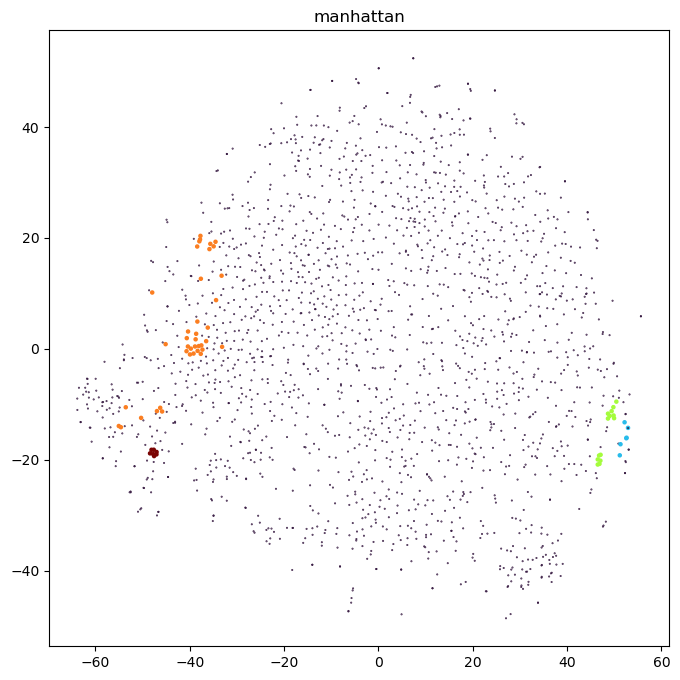

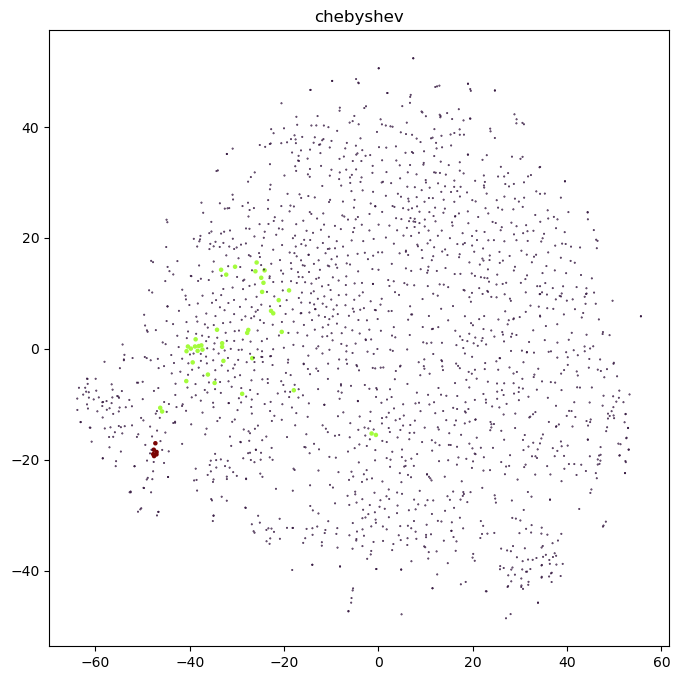

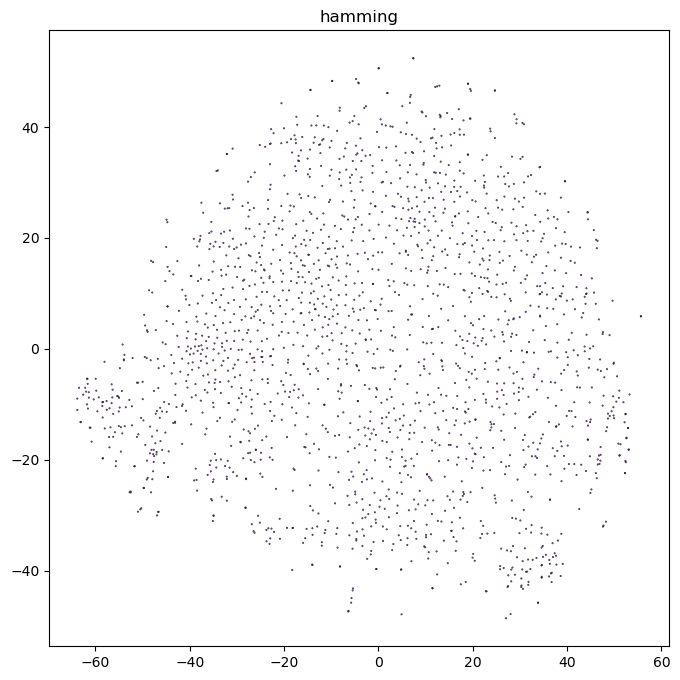

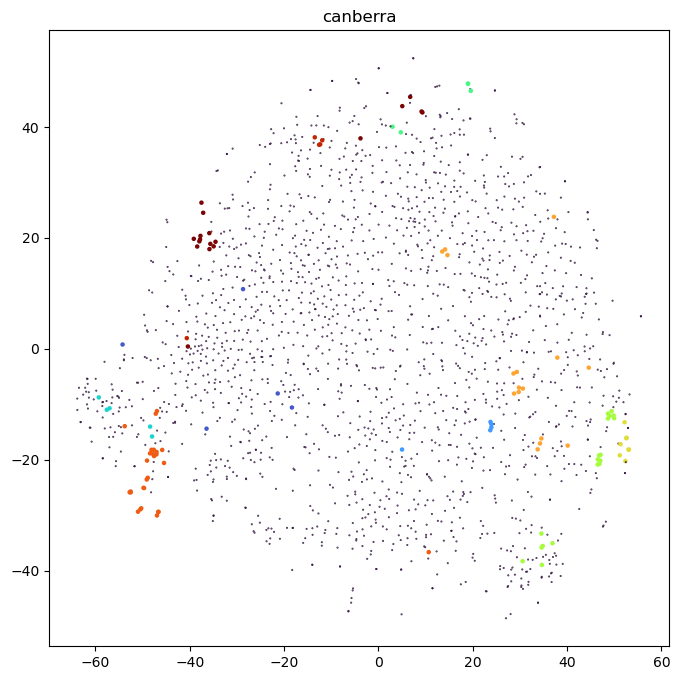

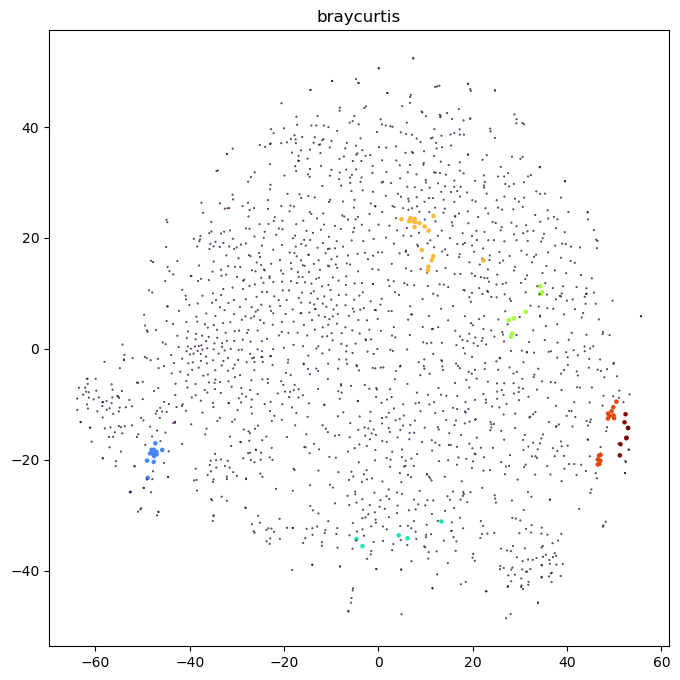

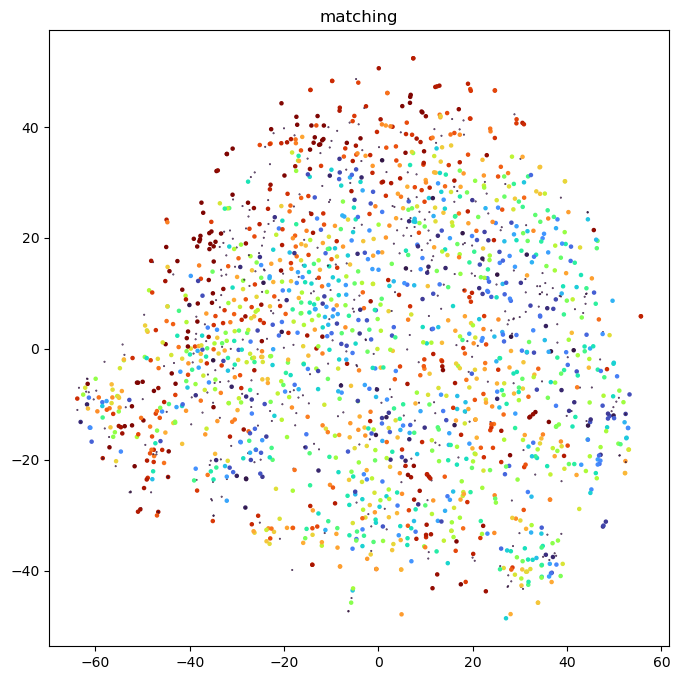

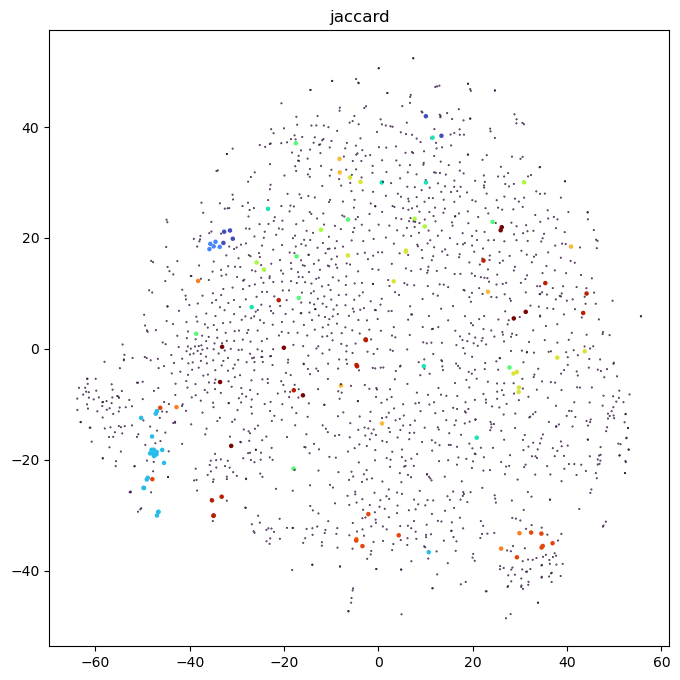

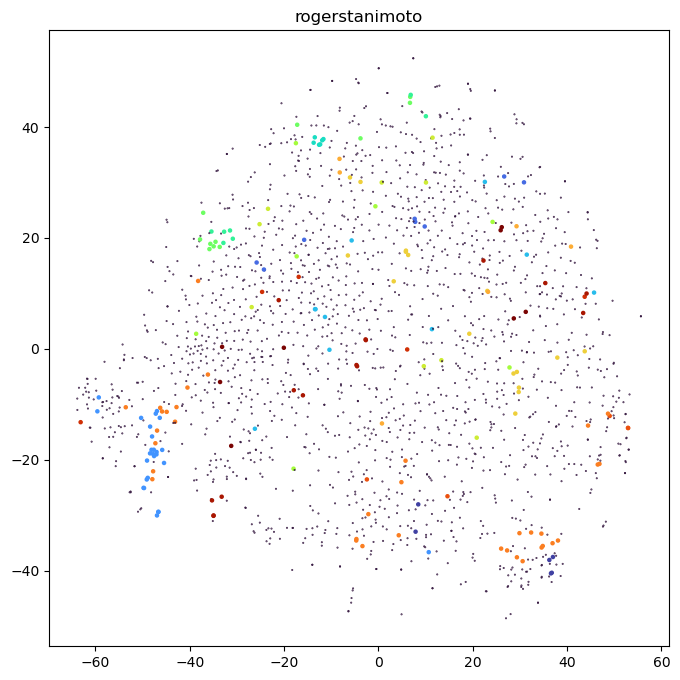

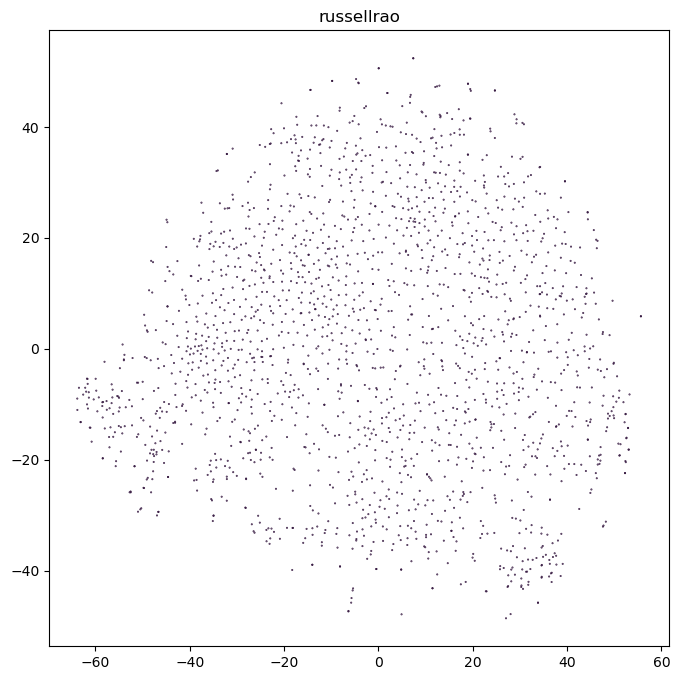

In [20]:
for metric in metric_label_dict:  
    labels = metric_label_dict[metric]
    fig, ax = plt.subplots(figsize=(8,8))
    s=np.ones((len(labels),1))*5
    s[labels==-1]=0.2
    c=labels
    ax.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=s, c=c*5, cmap="turbo")
    ax.set_title(metric)
    print( )

### Exploring Euclidean Clusters

In [51]:
label_dict = get_indices_by_label(metric_label_dict["euclidean"])
label_dict[0], label_dict[1]

([31, 930, 1087, 1257, 1281], [265, 816, 1056, 1340, 1355, 2850])

{'1': [[-30.0934, -30.0921, -30.0883, -30.0819, -30.0731, -30.0618, -30.0482, -30.0323, -30.0143, -29.9943, -29.9725, -29.9491, -29.9244, -29.8987, -29.8725, -29.8464, -29.8212, -29.798, -29.7788, -29.7658, -29.7611, -29.7611, -29.7614, -29.7623, -29.7636, -29.7652, -29.767, -29.7687, -29.7702, -29.7714, -29.7722, -29.7725, -29.7722, -29.7714, -29.7702, -29.7687, -29.767, -29.7653, -29.7637, -29.7623, -29.7615, -29.7612, -29.7612, -29.7576, -29.7469, -29.7293, -29.7052, -29.675, -29.6392, -29.626, -29.6716, -29.7209, -29.7719, -29.8231, -29.8728, -29.9198, -29.9629, -30.0011, -30.0335, -30.0593, -30.0781, -30.0896, -30.0934], [-29.1127, -29.1141, -29.1188, -29.1264, -29.137, -29.1504, -29.1665, -29.1852, -29.2062, -29.2293, -29.2542, -29.2807, -29.3084, -29.3369, -29.3657, -29.3941, -29.4213, -29.4459, -29.4663, -29.48, -29.4849, -29.4849, -29.4842, -29.4822, -29.479, -29.475, -29.4706, -29.466, -29.462, -29.4587, -29.4566, -29.4558, -29.4566, -29.4587, -29.4619, -29.466, -29.4705, -29

TypeError: iteration over a 0-d array

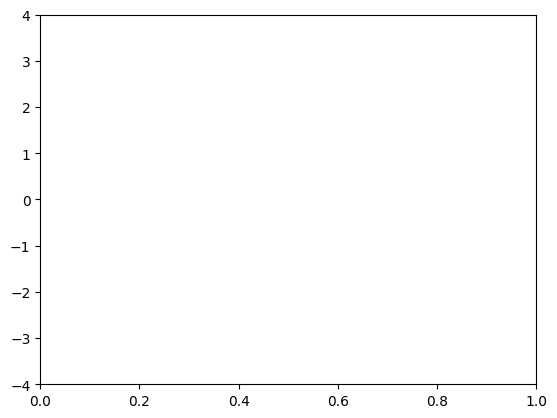

In [65]:
for name in label_dict[0]:
    BS_dir= '/media/tw/HDD/Misc/mphys/bands/'
    filename_bands=BS_dir+"2dm-"+str(name)+'.json'
    if not os.path.isfile(filename_bands):
        print("No such file %s" % filename_bands)
        continue
    bands_dict=json.load(open(filename_bands))
    
    fig, ax = plt.subplots()
    ax.set_ylim([-4, 4])

    print(bands_dict["bands"])
    bands = np.array(bands_dict["bands"]["1)

    for band in bands:
        ax.plot(band-bands_dict["efermi"])